In [14]:
import numpy as np
import pandas as pd
import pickle as pkl

import time
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm import tqdm

import warnings
warnings.filterwarnings("ignore")

In [15]:
from google.colab import drive
drive.mount("/content/drive/")

Drive already mounted at /content/drive/; to attempt to forcibly remount, call drive.mount("/content/drive/", force_remount=True).


In [16]:
# Setting up the possible latent dimensions
# A total of 27 latent dimensions are taken under consideration

k_list = []
k_list.extend(list(range(2, 10)))
k_list.extend(list(range(10, 20, 2)))
k_list.extend(list(range(20, 50, 5)))
k_list.extend(list(range(50, 61, 10)))
k_list.append(78)
k_list.extend(list(range(80, 100, 10)))
k_list.extend(list(range(100, 176, 25)))

print("Latent dimensions:")
print(k_list)

# list of algorithms/models
model_list = ["pca", "ica", "nmf", "vae", "dae"]
print(model_list)

Latent dimensions:
[2, 3, 4, 5, 6, 7, 8, 9, 10, 12, 14, 16, 18, 20, 25, 30, 35, 40, 45, 50, 60, 78, 80, 90, 100, 125, 150, 175]
['pca', 'ica', 'nmf', 'vae', 'dae']


In [17]:
num_cca_trials = 5
epsilon = 1e-6
threshold = 1e-6

def positivedef_matrix_sqrt(array):
  w, v = np.linalg.eigh(array)
  wsqrt = np.sqrt(w)
  sqrtarray = np.dot(v, np.dot(np.diag(wsqrt), np.conj(v).T))
  return sqrtarray

def remove_small(sigma_xx, sigma_xy, sigma_yx, sigma_yy, threshold=1e-6):
  x_diag = np.abs(np.diagonal(sigma_xx))
  y_diag = np.abs(np.diagonal(sigma_yy))
  x_idxs = (x_diag >= threshold)
  y_idxs = (y_diag >= threshold)

  sigma_xx_crop = sigma_xx[x_idxs][:, x_idxs]
  sigma_xy_crop = sigma_xy[x_idxs][:, y_idxs]
  sigma_yx_crop = sigma_yx[y_idxs][:, x_idxs]
  sigma_yy_crop = sigma_yy[y_idxs][:, y_idxs]

  return (sigma_xx_crop, sigma_xy_crop, sigma_yx_crop, sigma_yy_crop, x_idxs, y_idxs)


def compute_ccas(sigma_xx, sigma_xy, sigma_yx, sigma_yy, verbose=True):
  (sigma_xx, sigma_xy, sigma_yx, sigma_yy, x_idxs, y_idxs) = remove_small(sigma_xx, sigma_xy, sigma_yx, sigma_yy)

  numx = sigma_xx.shape[0]
  numy = sigma_yy.shape[0]

  if numx == 0 or numy == 0:
    return ([0, 0, 0], [0, 0, 0], np.zeros_like(sigma_xx),
            np.zeros_like(sigma_yy), x_idxs, y_idxs)

  if verbose:
    print("adding eps to diagonal and taking inverse")
  sigma_xx +=epsilon * np.eye(numx)
  sigma_yy +=epsilon * np.eye(numy)
  inv_xx = np.linalg.pinv(sigma_xx)
  inv_yy = np.linalg.pinv(sigma_yy)

  if verbose:
    print("taking square root")
  invsqrt_xx = positivedef_matrix_sqrt(inv_xx)
  invsqrt_yy = positivedef_matrix_sqrt(inv_yy)

  if verbose:
    print("dot products...")
  arr_x = np.dot(sigma_yx, invsqrt_xx)
  arr_x = np.dot(inv_yy, arr_x)
  arr_x = np.dot(invsqrt_xx, np.dot(sigma_xy, arr_x))
  arr_y = np.dot(sigma_xy, invsqrt_yy)
  arr_y = np.dot(inv_xx, arr_y)
  arr_y = np.dot(invsqrt_yy, np.dot(sigma_yx, arr_y))

  if verbose:
    print("trying to take final svd")
  arr_x_stable = arr_x + epsilon * np.eye(arr_x.shape[0])
  arr_y_stable = arr_y + epsilon * np.eye(arr_y.shape[0])
  try:
      ux, sx, vx = np.linalg.svd(arr_x_stable)
      uy, sy, vy = np.linalg.svd(arr_y_stable)
  except:
      return [0, 0, 0], [0, 0, 0], 0, 0, 0, 0
  sx = np.sqrt(np.abs(sx))
  sy = np.sqrt(np.abs(sy))
  if verbose:
    print("computed everything!")

  return [ux, sx, vx], [uy, sy, vy], invsqrt_xx, invsqrt_yy, x_idxs, y_idxs


def sum_threshold(array, threshold):
  assert (threshold >= 0) and (threshold <= 1), "print incorrect threshold"

  for i in range(len(array)):
    if np.sum(array[:i]) / np.sum(array) >= threshold:
      return i


def create_zero_dict(compute_dirns, dimension):
  return_dict = {}
  return_dict["mean"] = (np.asarray(0), np.asarray(0))
  return_dict["sum"] = (np.asarray(0), np.asarray(0))
  return_dict["cca_coef1"] = np.asarray(0)
  return_dict["cca_coef2"] = np.asarray(0)
  return_dict["idx1"] = 0
  return_dict["idx2"] = 0

  if compute_dirns:
    return_dict["cca_dirns1"] = np.zeros((1, dimension))
    return_dict["cca_dirns2"] = np.zeros((1, dimension))

  return return_dict


def get_cca_similarity(acts1, acts2, threshold=0.98, compute_dirns=True, verbose=True):
  # assert dimensionality equal
  assert acts1.shape[1] == acts2.shape[1], "dimensions don't match"
  # check that acts1, acts2 are transposition
  assert acts1.shape[0] < acts1.shape[1], ("input must be number of neurons by datapoints")
  return_dict = {}

  # compute covariance with numpy function for extra stability
  numx = acts1.shape[0]

  covariance = np.cov(acts1, acts2)
  sigmaxx = covariance[:numx, :numx]
  sigmaxy = covariance[:numx, numx:]
  sigmayx = covariance[numx:, :numx]
  sigmayy = covariance[numx:, numx:]

  # rescale covariance to make cca computation more stable
  xmax = np.max(np.abs(sigmaxx))
  ymax = np.max(np.abs(sigmayy))
  sigmaxx /= xmax
  sigmayy /= ymax
  sigmaxy /= np.sqrt(xmax * ymax)
  sigmayx /= np.sqrt(xmax * ymax)

  ([_, sx, vx], [_, sy, vy], invsqrt_xx, invsqrt_yy, x_idxs,
   y_idxs) = compute_ccas(sigmaxx, sigmaxy, sigmayx, sigmayy,
                          verbose)

  # if x_idxs or y_idxs is all false, return_dict has zero entries
  if (not np.any(x_idxs)) or (not np.any(y_idxs)):
    return create_zero_dict(compute_dirns, acts1.shape[1])

  if compute_dirns:
    # orthonormal directions that are CCA directions
    cca_dirns1 = np.dot(vx, np.dot(invsqrt_xx, acts1[x_idxs]))
    cca_dirns2 = np.dot(vy, np.dot(invsqrt_yy, acts2[y_idxs]))

  # get rid of trailing zeros in the cca coefficients
  idx1 = sum_threshold(sx, threshold)
  idx2 = sum_threshold(sy, threshold)

  return_dict["neuron_coeffs1"] = np.dot(vx, invsqrt_xx)
  return_dict["neuron_coeffs2"] = np.dot(vy, invsqrt_yy)
  return_dict["cca_coef1"] = sx
  return_dict["cca_coef2"] = sy
  return_dict["x_idxs"] = x_idxs
  return_dict["y_idxs"] = y_idxs
  # summary statistics
  return_dict["mean"] = (np.mean(sx[:idx1]), np.mean(sy[:idx2]))
  return_dict["sum"] = (np.sum(sx), np.sum(sy))

  if compute_dirns:
    return_dict["cca_dirns1"] = cca_dirns1
    return_dict["cca_dirns2"] = cca_dirns2

  return return_dict


def robust_cca_similarity(acts1, acts2, threshold=0.98, compute_dirns=True, verbose=False):
  for trial in range(num_cca_trials):
    try:
      return_dict = get_cca_similarity(acts1, acts2, threshold, compute_dirns, verbose=verbose)
    except np.LinAlgError:
      acts1 = acts1 * 1e-1 + np.random.normal(size=acts1.shape) * epsilon
      acts2 = acts2 * 1e-1 + np.random.normal(size=acts1.shape) * epsilon
      if trial + 1 == num_cca_trials:
        raise

  return return_dict

In [18]:
def get_svcca_across_z_stability(z_dict_a, z_dict_b, threshold=0.98):
    output_list = []
    result = robust_cca_similarity(z_dict_a, z_dict_b, verbose=False, threshold=threshold)
    output_list.append(np.mean(result["cca_coef1"]))

    # Convert output to pandas dataframe
    return pd.DataFrame(output_list, columns=["svcca_mean_similarity"])

In [19]:
f1 = open('/content/drive/MyDrive/aacb_project/datasets/z_dict_vae.p', 'rb')
vae_z_dict = pkl.load(f1)
f1.close()

f2 = open('/content/drive/MyDrive/aacb_project/datasets/z_dict_dae.p', 'rb')
dae_z_dict = pkl.load(f2)
f2.close()

f3 = open('/content/drive/MyDrive/aacb_project/datasets/z_dict_pca_ica_nmf.p', 'rb')
pca_ica_nmf_z_dict = pkl.load(f3)
f3.close()

In [20]:
z_dict = {}
for k in k_list:
  z_dict[k] = {'vae': vae_z_dict[k], 'dae': dae_z_dict[k], 'pca': pca_ica_nmf_z_dict[k]['pca'], 
                  'ica': pca_ica_nmf_z_dict[k]['ica'], 'nmf': pca_ica_nmf_z_dict[k]['nmf']}

In [21]:
dataset_svcca_results_list = []
for algorithm in model_list:
    print("Model:", algorithm)
    time.sleep(1)
    for z_a in tqdm(k_list):
        z_dict_a = z_dict[z_a][algorithm]
        z_bs = [x for x in k_list if x > z_a]
        for z_b in z_bs:
            z_dict_b = z_dict[z_b][algorithm]
            svcca_out = get_svcca_across_z_stability(z_dict_a, z_dict_b)
            svcca_out = svcca_out.assign(algorithm=algorithm, z_dim_a=z_a, z_dim_b=z_b)
            dataset_svcca_results_list.append(svcca_out)

Model: pca


100%|██████████| 28/28 [00:27<00:00,  1.02it/s]


Model: ica


100%|██████████| 28/28 [00:32<00:00,  1.17s/it]


Model: nmf


100%|██████████| 28/28 [00:34<00:00,  1.22s/it]


Model: vae


100%|██████████| 28/28 [00:35<00:00,  1.27s/it]


Model: dae


100%|██████████| 28/28 [00:36<00:00,  1.30s/it]


In [22]:
svcca_results_df = pd.concat(dataset_svcca_results_list).reset_index(drop=True)
svcca_results_df.columns = ['svcca_mean_similarity', 'algorithm', 'z_dim_a', 'z_dim_b']
svcca_results_df.head(10)

,svcca_mean_similarity,algorithm,z_dim_a,z_dim_b
0,0.999999,pca,2,3
1,0.999999,pca,2,4
2,0.999999,pca,2,5
3,0.999999,pca,2,6
4,0.999999,pca,2,7
5,0.999999,pca,2,8
6,0.999999,pca,2,9
7,0.999999,pca,2,10
8,0.999999,pca,2,12
9,0.999999,pca,2,14


In [23]:
mydf = svcca_results_df.copy(deep=True)
ans = [pd.DataFrame(y) for x, y in mydf.groupby('algorithm', as_index=False)]

In [26]:
algo_wise_dict = {'dae': ans[0].drop('algorithm', axis=1), 'ica': ans[1].drop('algorithm', axis=1), 
                  'nmf': ans[2].drop('algorithm', axis=1), 'pca': ans[3].drop('algorithm', axis=1),
                  'vae': ans[4].drop('algorithm', axis=1)}

In [27]:
k_pairs = []
for z_a in k_list:
    z_bs = [x for x in k_list if x > z_a]
    for z_b in z_bs:
        k_pairs.append((z_a, z_b))

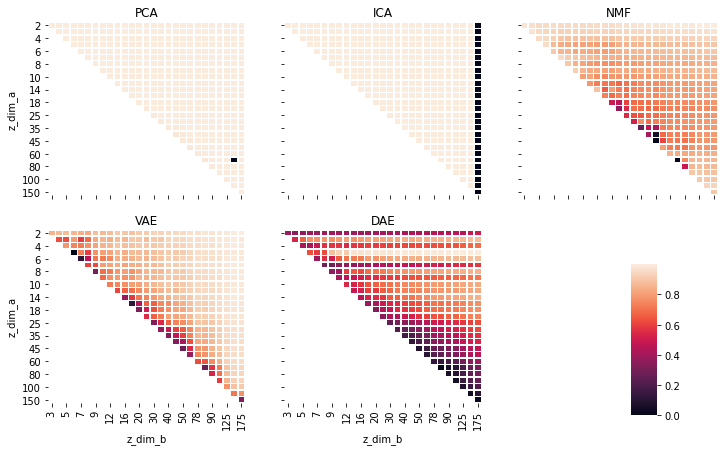

In [64]:
fig, axs = plt.subplots(2, 3, sharex=True, sharey=True, figsize=(12,7))
axs[-1, -1].axis('off')

cbar_ax = fig.add_axes([0.8, 0.1, 0.03, 0.3])

for i in range(2):
  for j in range(3):
    if i*3 + j < len(model_list):
      algo = model_list[i*3 + j]
      ans_algo = [pd.DataFrame(y) for x, y in algo_wise_dict[algo].groupby(['z_dim_a', 'z_dim_b'], as_index=False)]
      algo_across_k = [x.groupby(['z_dim_a','z_dim_b']).mean().reset_index() for x in ans_algo]
      algo_across_k = pd.concat(algo_across_k)
      f = sns.heatmap(algo_across_k.pivot('z_dim_a', 'z_dim_b', 'svcca_mean_similarity'), 
                      linewidths=.5, 
                      ax=axs[i,j],
                      cbar=(i*3 + j == 0),
                      cbar_ax=None if i else cbar_ax)
  
      f.set_title('{}'.format(algo.upper()))

for ax in axs.flat:
    ax.label_outer()

# fig.suptitle('Stability (SVCCA means) across latent dimensions')
# fig.tight_layout(rect=[0, 0, 1.5, 1.5])
plt.savefig('/content/drive/MyDrive/aacb_project/images/stability_across_latent_dimensions.png')

  